In [1]:
# reload modules if needed
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from notebook_utils import get_distribution_over_vocabulary, get_mlm_results, get_downstream_results
from scipy.spatial.distance import jensenshannon

import itertools


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
FIGURE_DIR = "/home/limisiewicz/my-luster/entangled-in-scripts/output/figures"
TABLE_DIR =  "/home/limisiewicz/my-luster/entangled-in-scripts/output/tables"

In [5]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 32
plt.rcParams['axes.labelsize'] = 26
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.titlesize'] = 26
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
plt.rcParams['legend.fontsize'] = 18

## Parameters

In [6]:
name_map = {
    'multilingual': 'Unigram',
    'bpe': 'BPE',
    'merged': 'TokMix',
    'nooverlap': 'NoOverlap'
}

In [7]:
languages = ('ar', 'tr', 'zh','el', 'es', 'en')
languages_by_script = ('ar', 'zh', 'el', 'tr', 'es', 'en')
same_script = list(itertools.permutations(('tr','es', 'en'), 2))

n_lang_pairs = len(languages) * (len(languages) - 1)
n_lang_pairs_ss = len(same_script)

alpha = 0.25
tokenization_types = ('multilingual', 'merged', 'nooverlap', 'bpe')
N_vocab = 120000

ft_type = 'PROBE'

In [8]:
X_lang_results = pd.DataFrame(columns=['task', 'metric', 'tokenizer','diff-script', 'same-script','all'])
X_lang_stds = pd.DataFrame(columns=['task', 'metric', 'tokenizer','diff-script', 'same-script','all'])

In [9]:
X_trans_results = pd.DataFrame(columns=['task', 'metric', 'tokenizer','src', 'tgt','value'])
X_trans_stds = pd.DataFrame(columns=['task', 'metric', 'tokenizer','src', 'tgt','vlue'])

# Tokenizers and Overlap Usage

In [10]:
# vocab_distributions = {tok_type: get_distribution_over_vocabulary(tok_type, alpha, N_vocab, languages) for 
#                       tok_type in tokenization_types}

In [11]:
vocab_distributions = dict()
vocab_dist_arrays = dict()
vocab_frequencies = dict()

for tok_type in tokenization_types:
    vocab_distributions[tok_type], vocab_frequencies[tok_type] \
        = get_distribution_over_vocabulary(tok_type, alpha, N_vocab, languages)
    vocab_dist_arrays[tok_type] = {lang: np.array(list(vocab_distributions[tok_type][lang].values()))
                                   for lang in languages + ('All',)}

## JSD across tokenizers

Jeensehn Shannon Divergence

In [12]:
jsd = {}

for t_idx, tokenization in enumerate(tokenization_types):
    jsd[tokenization] = {}
    for lang1, lang2 in itertools.product(languages, languages):
        jsd[tokenization][(lang1, lang2)] = jensenshannon(vocab_dist_arrays[tokenization][lang1],
                                                          vocab_dist_arrays[tokenization][lang2], base=2.) ** 2
    

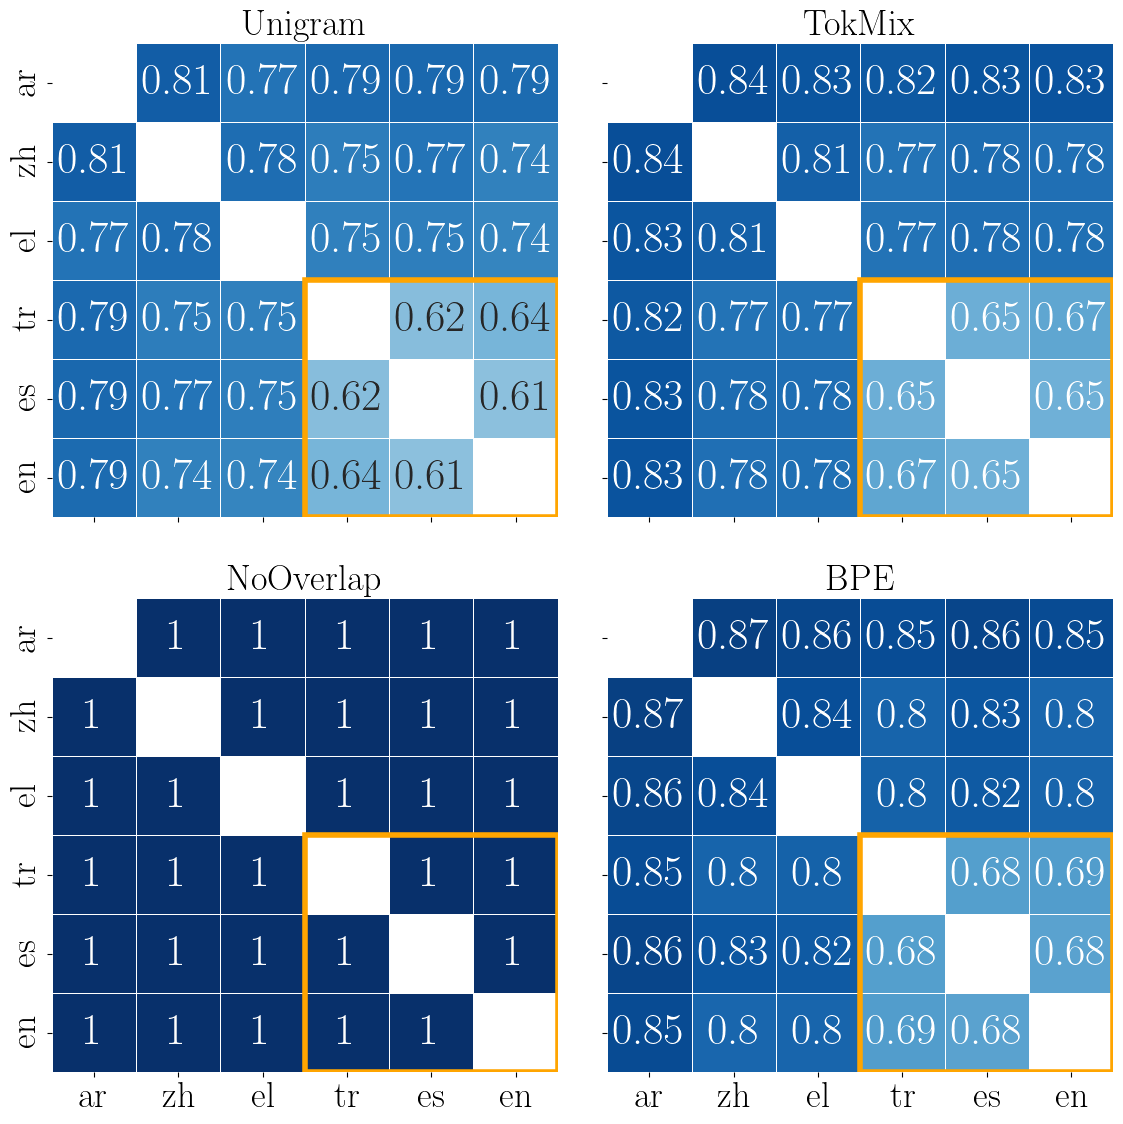

In [13]:
fig, axes = plt.subplots(2, 2,figsize=(12, 12),sharex=True,sharey=True)
axes = axes.ravel()

for t_idx, tokenization in enumerate(tokenization_types):
    ax = axes[t_idx]
    
    divergences = np.array([[jsd[tokenization][(lang1, lang2)] for lang1 in languages_by_script]
                            for lang2 in languages_by_script])
    mask = np.eye(divergences.shape[0], dtype='bool')
    
    sns.heatmap(divergences, mask=mask, annot=True, linewidths=.5, ax=axes[t_idx], cmap="Blues",
               vmin=0.4, vmax=.9, cbar=False)
    
    axes[t_idx].add_patch(patches.Rectangle(
         (3, 3), 3.0, 3.0,
         edgecolor='orange',fill=False, lw=4
     ) )
    
    axes[t_idx].set_xticks(np.arange(len(languages)) + 0.5, labels=languages_by_script)
    axes[t_idx].set_yticks(np.arange(len(languages)) + 0.5, labels=languages_by_script)
    axes[t_idx].set_title(f"{name_map[tokenization]}")
    
    

    
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "jensehnshannon_d.pdf"), dpi=300)
plt.show()

Average allocation

In [14]:
for tokenization in tokenization_types:
    jsd_est = {'task': 'overlap', 'metric': 'JSD', 'diff-script': 0., 'same-script': 0., 'all': 0.,
                'tokenizer': tokenization} 
    jsd_std = {'task': 'overlap', 'metric': 'JSD', 'diff-script': 0., 'same-script': 0., 'all': 0.,
                'tokenizer': tokenization} 

    for lang1, lang2 in itertools.product(languages, languages):
        if lang1 != lang2:
            jsd_est['all'] += jsd[tokenization][(lang1, lang2)] / n_lang_pairs
            if (lang1, lang2) in same_script:
                jsd_est['same-script'] += jsd[tokenization][(lang1, lang2)]/ n_lang_pairs_ss
            else:
                jsd_est['diff-script'] += jsd[tokenization][(lang1, lang2)] / (n_lang_pairs - n_lang_pairs_ss)
            X_trans_results = X_trans_results.append({'task': 'overlap', 'metric': 'JSD', 'tokenizer': tokenization, 
                                                      'src': lang1, 'tgt': lang2,
                                                      'value': jsd[tokenization][(lang1, lang2)]}, ignore_index=True)
            X_trans_stds = X_trans_stds.append({'task': 'overlap', 'metric': 'JSD', 'tokenizer': tokenization,
                                                'src': lang1, 'tgt': lang2,
                                                'value': 0.},ignore_index=True)

    X_lang_results = X_lang_results.append(jsd_est, ignore_index=True)
    X_lang_stds = X_lang_stds.append(jsd_std, ignore_index=True)

## Down-stream cross-lingual transfer (Heatmaps)


POS

In [15]:
pos_results = dict()
pos_stds = dict()

metrics = ('accuracy','f1-macro')
for tok_type in tokenization_types:
    pos_results[tok_type], pos_stds[tok_type] =  get_downstream_results(tok_type, alpha, N_vocab, languages,
                                                                        'POS',ft_type=ft_type, metrics=metrics,
                                                                        seeds=(1229, 1230, 1231, 1232, 1233))


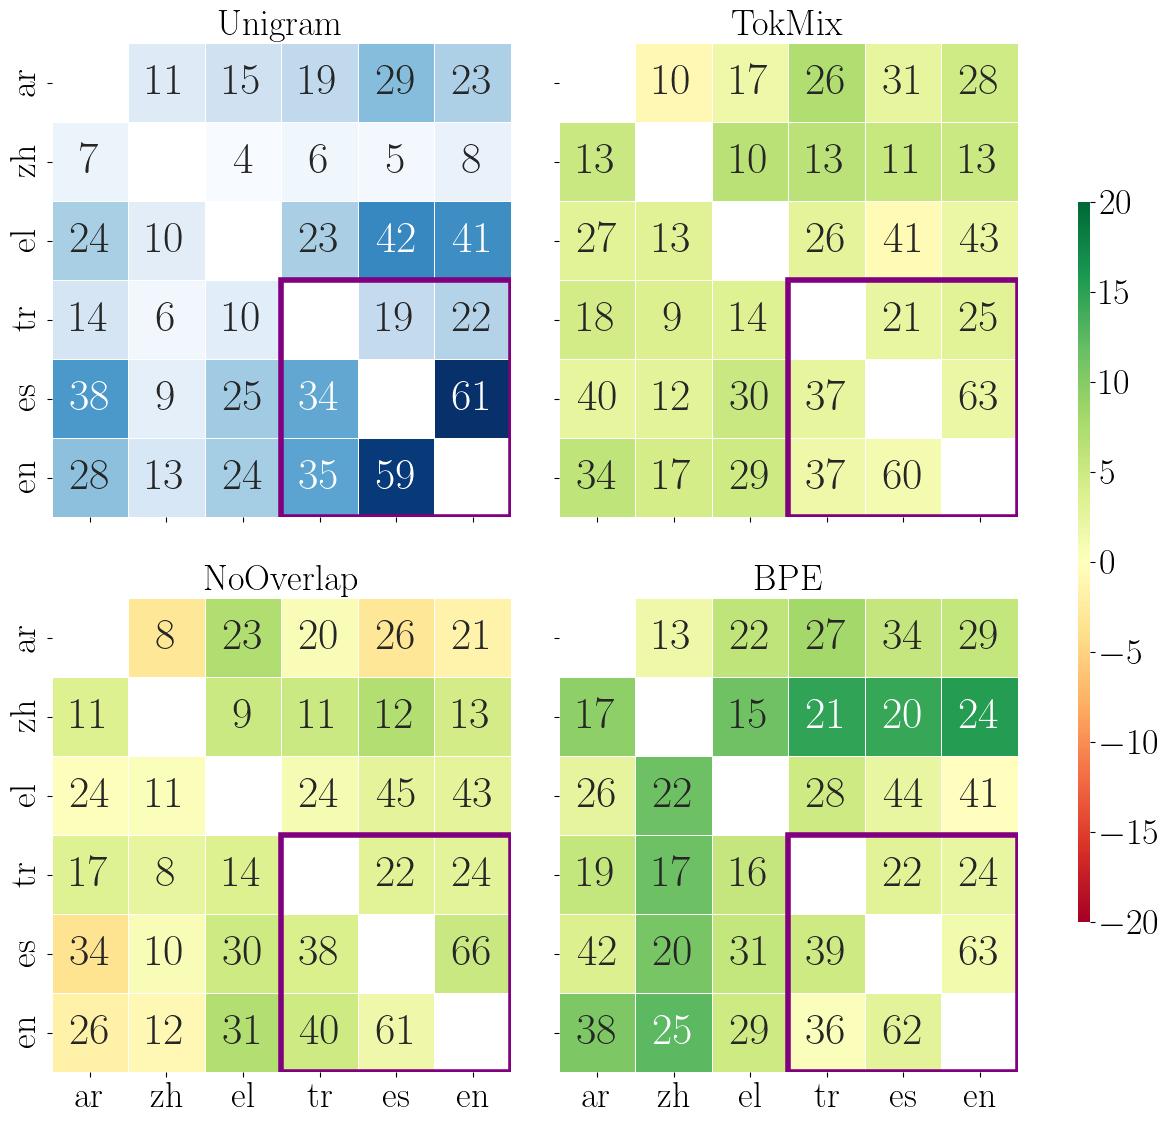

In [16]:
metric = 'f1-macro'
fig, axes = plt.subplots(2, 2,figsize=(12,12),sharex=True,sharey=True)
cbar_ax = fig.add_axes([0.93, .2, .01, .6])
axes = axes.ravel()
for t_id, tokenization in enumerate(tokenization_types):
    mask = np.eye(len(languages), dtype='bool')
    res = np.zeros_like(mask, dtype=np.float)
    for idx, lang1 in enumerate(languages_by_script):
        for jdx, lang2 in enumerate(languages_by_script):
            res[idx, jdx] = pos_results[tokenization][metric][lang1][lang2] * 100.

    if t_id== 0:
        res_base = res
        sns.heatmap(res, mask=mask,fmt='.0f', annot=True, linewidths=.5, ax=axes[t_id],
                    cmap="Blues", cbar=False)
    else:
        sns.heatmap(res - res_base,fmt='.0f', mask=mask, annot=res, linewidths=.5,
                    ax=axes[t_id], cmap='RdYlGn', vmin=-20., vmax=20., 
                    cbar= t_id == 1,
                    cbar_ax = None if (t_id!=1) else cbar_ax)

    axes[t_id].add_patch(patches.Rectangle(
         (3, 3), 3.0, 3.0,
         edgecolor='purple',fill=False, lw=4
     ) )
    
    axes[t_id].set_xticks(np.arange(len(languages_by_script)) + 0.5, labels=languages_by_script)
    axes[t_id].set_yticks(np.arange(len(languages_by_script)) + 0.5, labels=languages_by_script)
    axes[t_id].set_title(f"{name_map[tokenization]}")

#fig.suptitle("POS F1")
fig.tight_layout(rect=[0, 0,0.92, 1])
fig.savefig(os.path.join(FIGURE_DIR, "POS_F1_transfer.pdf"), dpi=300)
fig.show()

NER

In [17]:
ner_results = dict()
ner_stds = dict()

metrics = ('f1-seqeval','f1-macro')
for tok_type in tokenization_types:
    ner_results[tok_type], ner_stds[tok_type] =  get_downstream_results(tok_type, alpha, N_vocab, languages,
                                                                        'NER',ft_type=ft_type, metrics=metrics,
                                                                        seeds=(1229, 1230, 1231, 1232, 1233))


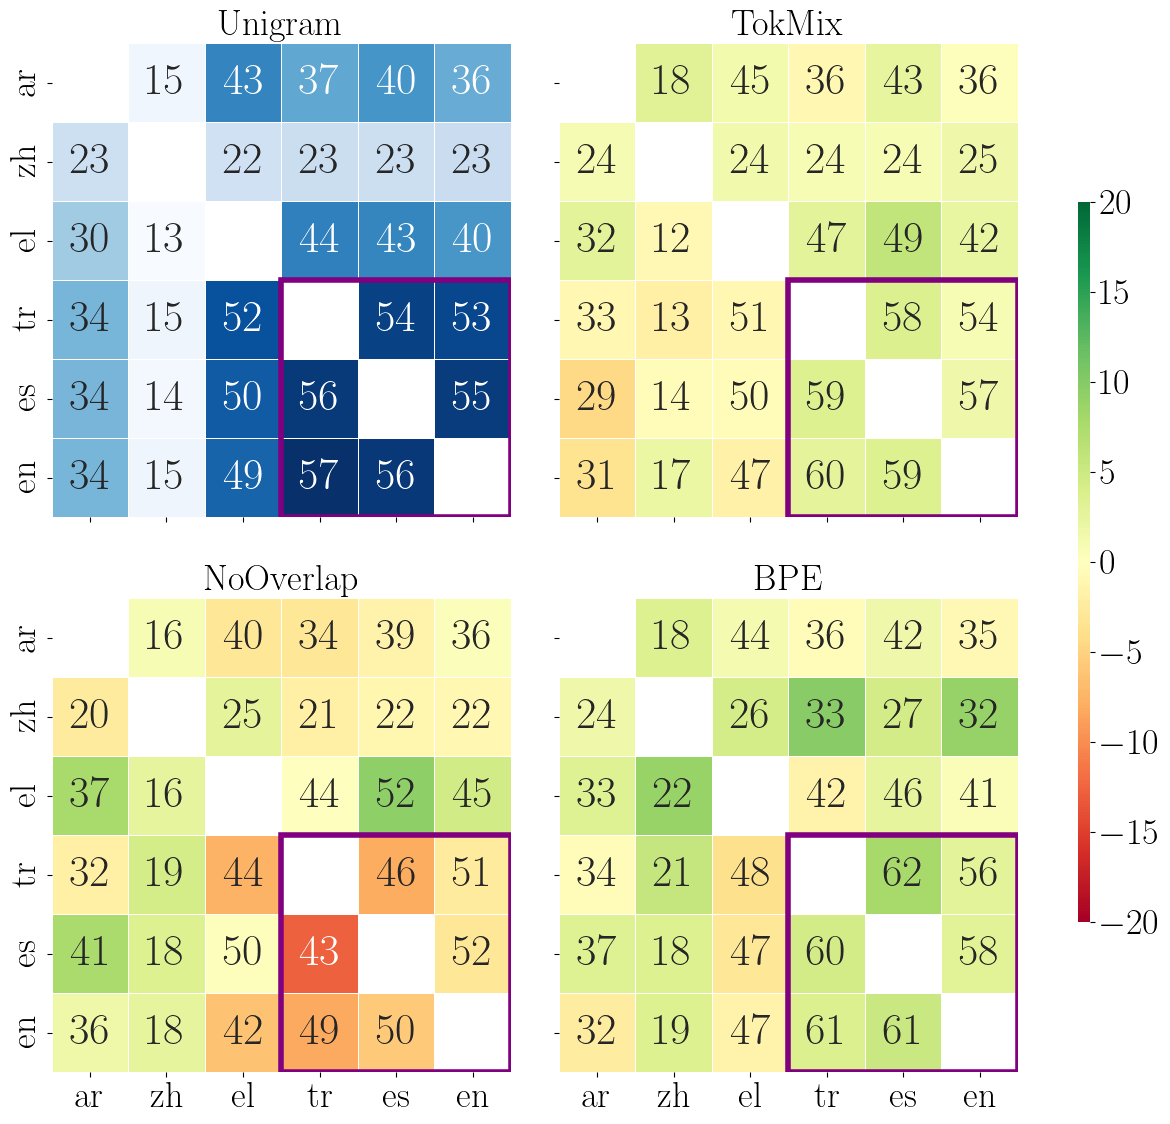

In [18]:
metric = 'f1-macro'
fig, axes = plt.subplots(2, 2,figsize=(12,12),sharex=True,sharey=True)
cbar_ax = fig.add_axes([0.93, .2, .01, .6])
axes = axes.ravel()
for t_id, tokenization in enumerate(tokenization_types):
    mask = np.eye(len(languages), dtype='bool')
    res = np.zeros_like(mask, dtype=np.float)
    for idx, lang1 in enumerate(languages_by_script):
        for jdx, lang2 in enumerate(languages_by_script):
            res[idx, jdx] = ner_results[tokenization][metric][lang1][lang2] * 100
    if t_id== 0:
        res_base = res
        sns.heatmap(res, mask=mask,fmt='.0f', annot=True, linewidths=.5, ax=axes[t_id],
                    cmap="Blues", cbar=False)
    else:
        sns.heatmap(res - res_base,fmt='.0f', mask=mask, annot=res, linewidths=.5,
                    ax=axes[t_id], cmap='RdYlGn', vmin=-20., vmax=20., 
                    cbar= t_id == 1,
                    cbar_ax = None if (t_id!=1) else cbar_ax)

    axes[t_id].add_patch(patches.Rectangle(
         (3, 3), 3.0, 3.0,
         edgecolor='purple',fill=False, lw=4
     ) )
    
    axes[t_id].set_xticks(np.arange(len(languages_by_script)) + 0.5, labels=languages_by_script)
    axes[t_id].set_yticks(np.arange(len(languages_by_script)) + 0.5, labels=languages_by_script)
    axes[t_id].set_title(f"{name_map[tokenization]}")
#fig.suptitle("NER F1")

fig.tight_layout(rect=[0, 0,0.92, 1])
fig.savefig(os.path.join(FIGURE_DIR, "NER_F1_transfer.pdf"), dpi=300)
fig.show()

XNLI

In [19]:
xnli_results = dict()
xnli_stds = dict()

metrics = ('accuracy',)
for tok_type in tokenization_types:
    xnli_results[tok_type], xnli_stds[tok_type] =  get_downstream_results(tok_type, alpha, N_vocab, languages,
                                                                        'XNLI', ft_type=ft_type, metrics=metrics,
                                                                        seeds=(2000,2001,2002,2003,2004))

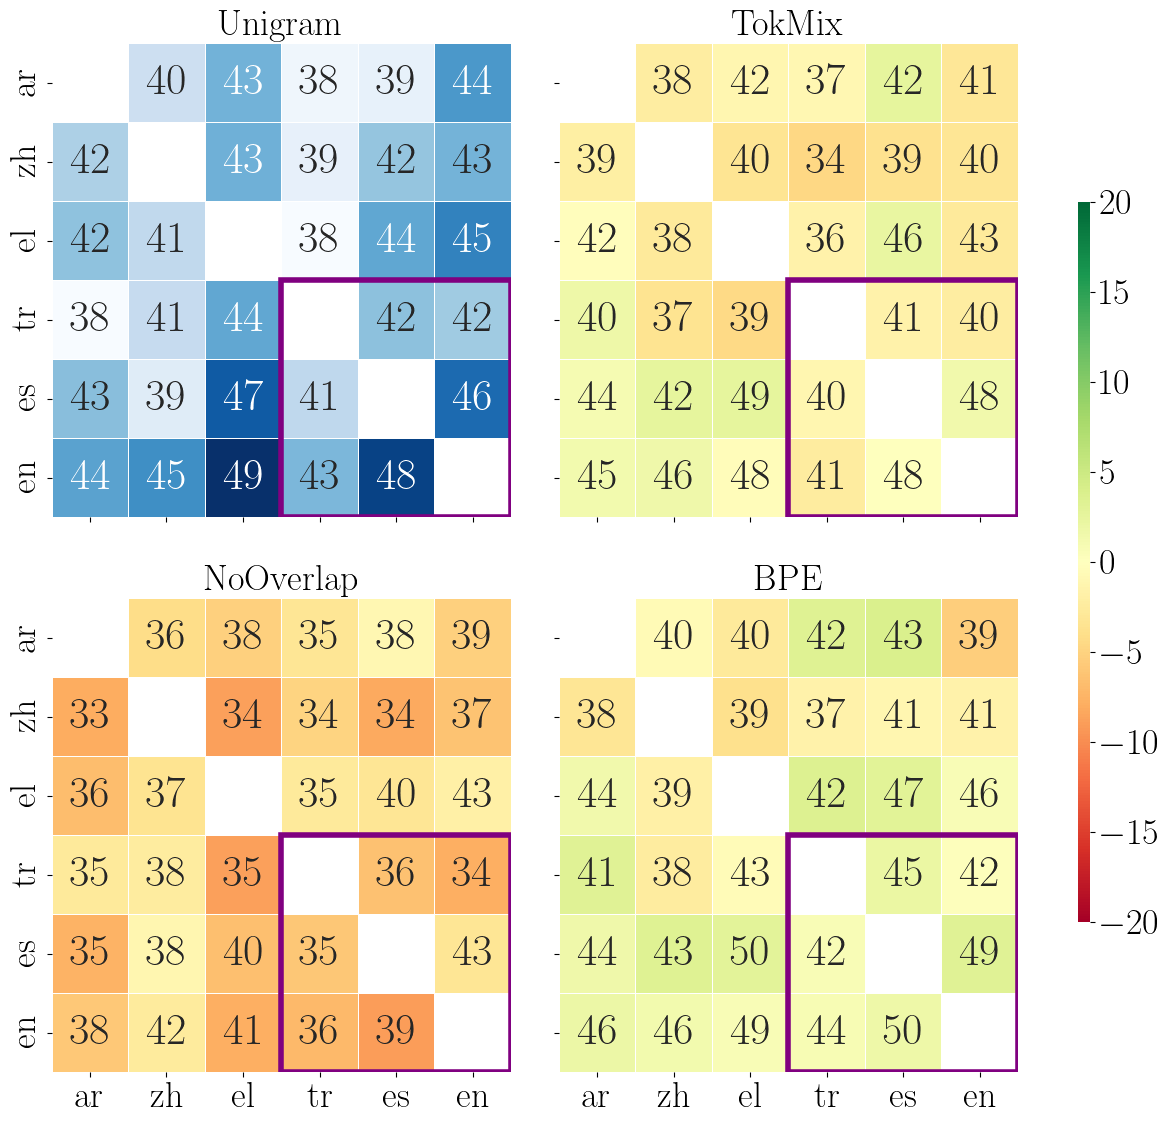

In [20]:
metric = 'accuracy'
fig, axes = plt.subplots(2, 2,figsize=(12,12),sharex=True,sharey=True)
cbar_ax = fig.add_axes([0.93, .2, .01, .6])
axes = axes.ravel()
for t_id, tokenization in enumerate(tokenization_types):
    mask = np.eye(len(languages), dtype='bool')
    res = np.zeros_like(mask, dtype=np.float)
    for idx, lang1 in enumerate(languages_by_script):
        for jdx, lang2 in enumerate(languages_by_script):
            res[idx, jdx] = xnli_results[tokenization][metric][lang1][lang2] * 100

    if t_id== 0:
        res_base = res
        sns.heatmap(res, mask=mask,fmt='.0f', annot=True, linewidths=.5, ax=axes[t_id],
                    cmap="Blues", cbar=False)
    else:
        sns.heatmap(res - res_base,fmt='.0f', mask=mask, annot=res, linewidths=.5,
                    ax=axes[t_id], cmap='RdYlGn', vmin=-20., vmax=20., 
                    cbar= t_id == 1,
                    cbar_ax = None if (t_id!=1) else cbar_ax)

    axes[t_id].add_patch(patches.Rectangle(
         (3, 3), 3.0, 3.0,
         edgecolor='purple',fill=False, lw=4
     ) )
    
    axes[t_id].set_xticks(np.arange(len(languages_by_script)) + 0.5, labels=languages_by_script)
    axes[t_id].set_yticks(np.arange(len(languages_by_script)) + 0.5, labels=languages_by_script)
    axes[t_id].set_title(f"{name_map[tokenization]}")
#fig.suptitle("XNLI Accuracy")

fig.tight_layout(rect=[0, 0,0.92, 1])
fig.savefig(os.path.join(FIGURE_DIR, "XNLI_Acc_transfer.pdf"), dpi=300)
fig.show()

Tatoeba

In [21]:
tatoeba_results = dict()
tatoeba_stds = dict()

metrics = ('accuracy',)
for tok_type in tokenization_types:
    tatoeba_results[tok_type], tatoeba_stds[tok_type] =  get_downstream_results(tok_type, alpha, N_vocab, languages,
                                                                        'ALIGN', ft_type='', metrics=metrics,
                                                                        seeds=(1234,))

/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/ar/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/tr/accuracy_evaluation/tr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/zh/accuracy_evaluation/zh/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/el/accuracy_evaluation/el/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/es/accuracy_evaluation/es/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/multilingual-token

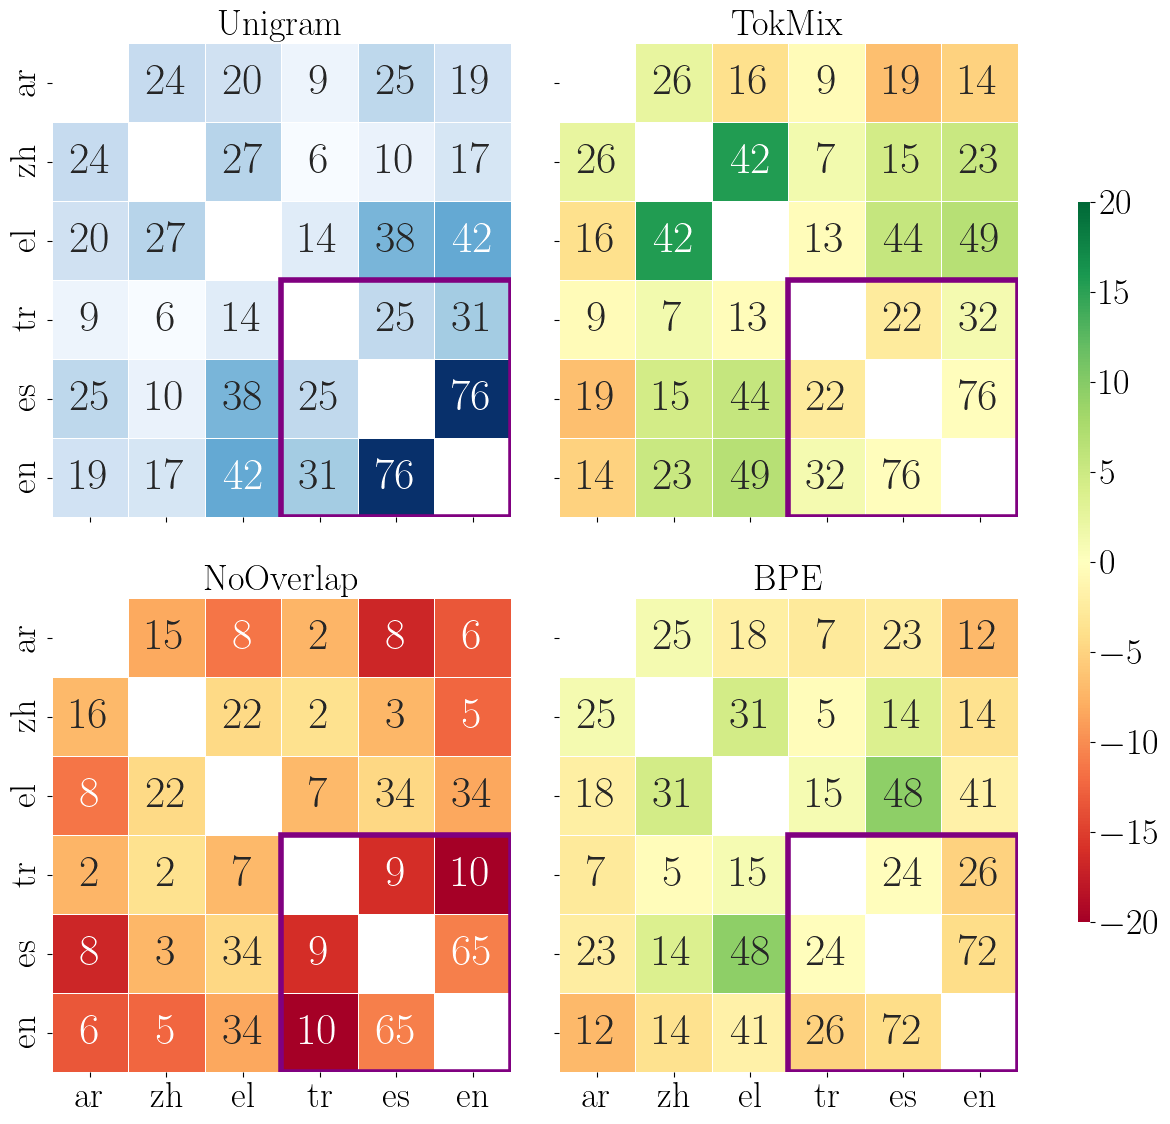

In [22]:
metric = 'accuracy'
fig, axes = plt.subplots(2, 2,figsize=(12,12),sharex=True,sharey=True)
cbar_ax = fig.add_axes([0.93, .2, .01, .6])
axes = axes.ravel()
for t_id, tokenization in enumerate(tokenization_types):
    mask = np.eye(len(languages), dtype='bool')
    res = np.zeros_like(mask, dtype=np.float)
    for idx, lang1 in enumerate(languages_by_script):
        for jdx, lang2 in enumerate(languages_by_script):
            res[idx, jdx] = tatoeba_results[tokenization][metric][lang1][lang2] * 100

    if t_id== 0:
        res_base = res
        sns.heatmap(res, mask=mask,fmt='.0f', annot=True, linewidths=.5, ax=axes[t_id],
                    cmap="Blues", cbar=False)
    else:
        sns.heatmap(res - res_base,fmt='.0f', mask=mask, annot=res, linewidths=.5,
                    ax=axes[t_id], cmap='RdYlGn', vmin=-20., vmax=20., 
                    cbar= t_id == 1,
                    cbar_ax = None if (t_id!=1) else cbar_ax)

    axes[t_id].add_patch(patches.Rectangle(
         (3, 3), 3.0, 3.0,
         edgecolor='purple',fill=False, lw=4
     ) )
    
    axes[t_id].set_xticks(np.arange(len(languages_by_script)) + 0.5, labels=languages_by_script)
    axes[t_id].set_yticks(np.arange(len(languages_by_script)) + 0.5, labels=languages_by_script)
    axes[t_id].set_title(f"{name_map[tokenization]}")

#fig.suptitle("Tatoeba Accuracy")

fig.tight_layout(rect=[0, 0,0.92, 1])
fig.savefig(os.path.join(FIGURE_DIR, "Tatoeba_Acc_transfer.pdf"), dpi=300)
fig.show()

## Cross-lingual transfer (aggregates)

In [23]:
def update_tables(results, stds, task, metric, languages, metric_new=None):
    global X_trans_results
    global X_trans_stds
    
    global X_lang_results
    global X_lang_stds
    if not metric_new:
        metric_new = metric
        
    for tokenization in tokenization_types:
    
        est = {'task': task, 'metric': metric, 'diff-script': 0., 'same-script': 0., 'all': 0.,
                    'tokenizer': tokenization} 
        std = {'task': task, 'metric': metric, 'diff-script': 0., 'same-script': 0., 'all': 0.,
                    'tokenizer': tokenization} 

        for lang1, lang2 in itertools.product(languages, languages):
            if lang1 != lang2:


                est['all'] += results[tokenization][metric][lang1][lang2] / n_lang_pairs
                std['all'] += stds[tokenization][metric][lang1][lang2] / n_lang_pairs
                if (lang1, lang2) in same_script:
                    est['same-script'] += results[tokenization][metric][lang1][lang2] / n_lang_pairs_ss
                    std['same-script'] += stds[tokenization][metric][lang1][lang2] / n_lang_pairs_ss
                else:
                    est['diff-script'] += results[tokenization][metric][lang1][lang2] / (n_lang_pairs - n_lang_pairs_ss)
                    std['diff-script'] += stds[tokenization][metric][lang1][lang2] / (n_lang_pairs - n_lang_pairs_ss)
                X_trans_results = X_trans_results.append({'task': task, 'metric': metric_new, 'tokenizer': tokenization, 
                                        'src': lang1, 'tgt': lang2,
                                        'value': results[tokenization][metric][lang1][lang2]}, ignore_index=True)
                X_trans_stds = X_trans_stds.append({'task': task, 'metric': metric_new, 'tokenizer': tokenization,
                                     'src': lang1, 'tgt': lang2,
                                     'value': stds[tokenization][metric][lang1][lang2]}, ignore_index=True)
        X_lang_results = X_lang_results.append(est, ignore_index=True)
        X_lang_stds = X_lang_stds.append(std, ignore_index=True)
    

In [24]:
update_tables(pos_results, pos_stds, 'POS', 'f1-macro', languages, metric_new='F1')

In [25]:
update_tables(ner_results, ner_stds, 'NER', 'f1-macro', languages, metric_new='F1')

In [26]:
update_tables(xnli_results, xnli_stds, 'XNLI', 'accuracy', languages, metric_new='Acc')

In [27]:
update_tables(tatoeba_results, tatoeba_stds, 'Tatoeba', 'accuracy', languages, metric_new='Acc')

# Correlation Analysis

In [28]:
X_lang_results

,task,metric,tokenizer,diff-script,same-script,all
0,overlap,JSD,multilingual,0.769292,0.619949,0.739424
1,overlap,JSD,merged,0.801649,0.653752,0.772069
2,overlap,JSD,nooverlap,1.000000,1.000000,1.000000
3,overlap,JSD,bpe,0.830488,0.682589,0.800908
4,POS,f1-macro,multilingual,0.181203,0.383433,0.221649
5,POS,f1-macro,merged,0.219131,0.404319,0.256169
6,POS,f1-macro,nooverlap,0.201148,0.419260,0.244771
7,POS,f1-macro,bpe,0.258032,0.408102,0.288046
8,NER,f1-macro,multilingual,0.312745,0.553518,0.360899
9,NER,f1-macro,merged,0.317980,0.580329,0.370450


In [29]:
X_lang_stds

,task,metric,tokenizer,diff-script,same-script,all
0,overlap,JSD,multilingual,0.000000,0.000000,0.000000
1,overlap,JSD,merged,0.000000,0.000000,0.000000
2,overlap,JSD,nooverlap,0.000000,0.000000,0.000000
3,overlap,JSD,bpe,0.000000,0.000000,0.000000
4,POS,f1-macro,multilingual,0.004425,0.004327,0.004405
5,POS,f1-macro,merged,0.004271,0.003313,0.004079
6,POS,f1-macro,nooverlap,0.004531,0.005426,0.004710
7,POS,f1-macro,bpe,0.004985,0.004085,0.004805
8,NER,f1-macro,multilingual,0.004306,0.002207,0.003886
9,NER,f1-macro,merged,0.004376,0.002705,0.004042


## Create Table

In [30]:
def format_text(mean, std=0. ,mult=1., dec=1, with_stds=False):
    mean = round(mean * mult, dec)
    std = round(std * mult, dec)
    if dec == 0:
        mean = int(mean)
        std = int(mean)
        
    if mean is np.nan:
        return "-"

    if with_stds:
        return f"{mean} $_{{\pm{std}}}$"
    else:
        return f"{mean}"



def preprocess_table(table):
    table['metric'] = [r[1]['task'] if r[1]['task']  not in ('overlap')
              else r[1]['metric'] for r in table.iterrows()]
    table= table.drop(columns=['task'])
    
    table = table[table['metric']  != 'BPC']
    table = table.replace({'tokenizer': name_map})
    table.set_index(['metric', 'tokenizer'], inplace=True)
    return table


def textify_results(res, stds):
    for i, row in res.iterrows():
        if i[0] == 'JSD':
            res.loc[i] = [format_text(v, dec=2) for v in row]
        elif i[0] == 'Tatoeba':
            res.loc[i] = [format_text(v, mult=100, dec=1) for v in row]
        else:
            res.loc[i] = [format_text(v, std=s, mult=100., with_stds=True) for v, s in zip(row, stds.loc[i])]

    return res
    

In [31]:
tab_res = preprocess_table(X_lang_results)
tab_std = preprocess_table(X_lang_stds)

out_X_lang = textify_results(tab_res, tab_std)
out_X_lang

diff-script       same-script               all
metric  tokenizer                                                      
JSD     Unigram                0.77              0.62              0.74
        TokMix                  0.8              0.65              0.77
        NoOverlap               1.0               1.0               1.0
        BPE                    0.83              0.68               0.8
POS     Unigram    18.1 $_{\pm0.4}$  38.3 $_{\pm0.4}$  22.2 $_{\pm0.4}$
        TokMix     21.9 $_{\pm0.4}$  40.4 $_{\pm0.3}$  25.6 $_{\pm0.4}$
        NoOverlap  20.1 $_{\pm0.5}$  41.9 $_{\pm0.5}$  24.5 $_{\pm0.5}$
        BPE        25.8 $_{\pm0.5}$  40.8 $_{\pm0.4}$  28.8 $_{\pm0.5}$
NER     Unigram    31.3 $_{\pm0.4}$  55.4 $_{\pm0.2}$  36.1 $_{\pm0.4}$
        TokMix     31.8 $_{\pm0.4}$  58.0 $_{\pm0.3}$  37.0 $_{\pm0.4}$
        NoOverlap  32.0 $_{\pm0.5}$  48.6 $_{\pm0.4}$  35.3 $_{\pm0.5}$
        BPE        33.5 $_{\pm0.5}$  59.9 $_{\pm0.2}$  38.7 $_{\pm0.4}$
XNLI    Unigram    42.2 $_{\pm0.7}$  43.7 $_{\pm0.7}$  42.5 $_{\pm0.7}$
        TokMix     41.2 $_{\pm0.7}$  42.7 $_{\pm0.5}$  41.5 $_{\pm0.7}$
        NoOverlap  37.3 $_{\pm0.6}$  37.1 $_{\pm0.5}$  37.2 $_{\pm0.6}$
        BPE        42.4 $_{\pm0.7}$  45.2 $_{\pm0.8}$  43.0 $_{\pm0.7}$
Tatoeba Unigram                21.0              43.9              25.6
        TokMix                 23.0              43.4              27.1
        NoOverlap              12.3              28.0              15.4
        BPE                    20.9              40.7              24.9

In [32]:
out_X_lang.to_latex(os.path.join(TABLE_DIR,"X_lang.tex"), index=True,multirow=True,
                          longtable=False, escape=False, encoding="UTF-8",
                        caption="Results of evaluation for cros-languages overlaps and transfers for six diverse languages."
                        "We observe significant changes for different tokenization methods.",
                        label="tab:X_lang")

## Cross-lingual correlation analysis

In [33]:
X_trans_results

,task,metric,tokenizer,src,tgt,value
0,overlap,JSD,multilingual,ar,tr,0.790010
1,overlap,JSD,multilingual,ar,zh,0.813243
2,overlap,JSD,multilingual,ar,el,0.770051
3,overlap,JSD,multilingual,ar,es,0.791744
4,overlap,JSD,multilingual,ar,en,0.786082
...,...,...,...,...,...,...
595,Tatoeba,Acc,bpe,en,ar,0.121000
596,Tatoeba,Acc,bpe,en,tr,0.257000
597,Tatoeba,Acc,bpe,en,zh,0.137000
598,Tatoeba,Acc,bpe,en,el,0.406000
